# Goal

* Simulating a fullCyc control gradient
  * Not simulating incorporation (all 0% isotope incorp.)
    * Don't know how much true incorporatation for emperical data
* Using parameters inferred from TRIMMED emperical data (fullCyc seq data), or if not available, default SIPSim parameters
* Determining whether simulated taxa show similar distribution to the emperical  data

## Input parameters
  * phyloseq.bulk file 
  * taxon mapping file
  * list of genomes
  * fragments simulated for all genomes
  * bulk community richness


## workflow

* Creating a community file from OTU abundances in bulk soil samples
  * phyloseq.bulk --> OTU table --> filter to sample --> community table format
* Fragment simulation
  * simulated_fragments --> parse out fragments for target OTUs 
  * simulated_fragments --> parse out fragments from random genomes to obtain richness of interest
  * combine fragment python objects
* Convert fragment lists to kde object
* Add diffusion
* Make incorp config file
* Add isotope incorporation
* Calculating BD shift from isotope incorp
* Simulating gradient fractions
* Simulating OTU table
* Simulating PCR
* Subsampling from the OTU table

## Init

In [80]:
import os
import glob
import re
import nestly

In [81]:
%load_ext rpy2.ipython
%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The pushnote extension is already loaded. To reload it, use:
  %reload_ext pushnote


In [82]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

### BD min/max

In [83]:
%%R
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

cat('Min BD:', min_BD, '\n')
cat('Max BD:', max_BD, '\n')

Min BD: 1.67323 
Max BD: 1.7744 


# Nestly

* assuming fragments already simulated

In [170]:
workDir = '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/'
buildDir = os.path.join(workDir, 'rep3_DBL-comm')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags_kde_parsed.pkl'
commFile = '/home/nick/notebook/SIPSim/dev/fullCyc//fullCyc_12C-Con_trm_comm.txt'

nreps = 10

In [171]:
# building tree structure
nest = nestly.Nest()

# varying params
nest.add('rep', [x + 1 for x in xrange(nreps)])


## set params
nest.add('abs', ['1e9'], create_dir=False)
nest.add('percIncorp', [0], create_dir=False)
nest.add('percTaxa', [0], create_dir=False)
nest.add('np', [10], create_dir=False)
nest.add('subsample_dist', ['lognormal'], create_dir=False)
nest.add('subsample_mean', [9.432], create_dir=False)
nest.add('subsample_scale', [0.5], create_dir=False)
nest.add('subsample_min', [10000], create_dir=False)
nest.add('subsample_max', [30000], create_dir=False)
nest.add('bandwidth', [0.08], create_dir=False)
nest.add('DBL_scaling', [0.4], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('commFile', [commFile], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [172]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

echo '#-- SIPSim pipeline --#'

echo '# shuffling taxa in comm file'
comm_shuffle_taxa.r {commFile} > comm.txt

echo '# adding diffusion'    
SIPSim diffusion \
    {fragFile} \
    --bw {bandwidth} \
    --np {np} \
    > ampFrags_KDE_dif.pkl    

echo '# adding DBL contamination; abundance-weighted smearing'
SIPSim DBL \
    ampFrags_KDE_dif.pkl \
    --comm comm.txt \
    --commx {DBL_scaling} \
    --bw {bandwidth} \
    --np {np} \
    > ampFrags_KDE_dif_DBL.pkl
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  > {percTaxa}_{percIncorp}.config

echo '# adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    ampFrags_KDE_dif_DBL.pkl \
    {percTaxa}_{percIncorp}.config \
    --comm comm.txt \
    --bw {bandwidth} \
    --np {np} \
    > ampFrags_KDE_dif_DBL_inc.pkl

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    comm.txt \
    > fracs.txt 

echo '# simulating an OTU table'
SIPSim OTU_table \
    ampFrags_KDE_dif_DBL_inc.pkl \
    comm.txt \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
#-- w/ PCR simulation --#
echo '# simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt
    

#-- w/out PCR simulation --#    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_meta.txt    

Overwriting /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/SIPSimRun.sh


In [ ]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d rep3_DBL-comm --log-file log.txt -j 2

2016-02-20 12:43:05,905 * INFO * Template: ./SIPSimRun.sh
2016-02-20 12:43:05,907 * INFO * [124224] Started ./SIPSimRun.sh in rep3_DBL-comm/7
2016-02-20 12:43:05,909 * INFO * [124225] Started ./SIPSimRun.sh in rep3_DBL-comm/9


In [ ]:
%pushnote rep3_DBL-comm complete

# BD min/max

* what is the min/max BD that we care about?

In [175]:
%%R
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

cat('Min BD:', min_BD, '\n')
cat('Max BD:', max_BD, '\n')

Min BD: 1.67323 
Max BD: 1.7744 


# Loading non-PCR subsampled OTU tables

In [176]:
OTU_files = !find $buildDir -name "OTU_abs1e9_sub.txt"
OTU_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/7/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/9/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/8/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/3/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/10/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/2/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/1/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/4/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/5/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_D

In [177]:
%%R -i OTU_files
# loading files

df.SIM = list()
for (x in OTU_files){
    df = read.delim(x, sep='\t')
    xx = strsplit(x, '/')[[1]]
    df$SIM_rep = xx[10] %>% as.numeric
    df.SIM[[x]] = df
    }
df.SIM = do.call('rbind', df.SIM)
rownames(df.SIM) = 1:nrow(df.SIM)
df.SIM %>% head(n=3)

  library    fraction                          taxon BD_min BD_mid BD_max count
1       1  -inf-1.660 Acaryochloris_marina_MBIC11017   -Inf  1.659  1.659     0
2       1 1.660-1.664 Acaryochloris_marina_MBIC11017  1.660  1.662  1.664     0
3       1 1.664-1.667 Acaryochloris_marina_MBIC11017  1.664  1.665  1.667     1
     rel_abund SIM_rep
1 0.000000e+00       7
2 0.000000e+00       7
3 4.868786e-05       7


# BD range where an OTU is detected 

* Do the simulated OTU BD distributions span the same BD range of the emperical data?

In [178]:
comm_files = !find $buildDir -name "comm.txt"
comm_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/7/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/9/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/8/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/3/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/10/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/2/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/1/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/4/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/5/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/6/comm.txt']

In [179]:
%%R -i comm_files

df.SIM.comm = list()
for (x in comm_files){
    df = read.delim(x, sep='\t')
    xx = strsplit(x, '/')[[1]]
    df$SIM_rep = xx[10] %>% as.numeric
    df.SIM.comm[[x]] = df
    }

df.SIM.comm = do.call(rbind, df.SIM.comm)
rownames(df.SIM.comm) = 1:nrow(df.SIM.comm)
df.SIM.comm = df.SIM.comm %>%
    rename('bulk_abund' = rel_abund_perc) %>%
    mutate(bulk_abund = bulk_abund / 100)
df.SIM.comm %>% head(n=3)

  library                   taxon_name bulk_abund rank SIM_rep
1       1 Halobacteriovorax_marinus_SJ 0.05728702    1       7
2       1 Zunongwangia_profunda_SM-A87 0.04295700    2       7
3       1   Staphylococcus_warneri_SG1 0.02965853    3       7


In [180]:
%%R

## joining SIP & comm (pre-fractionation)
df.SIM.j = inner_join(df.SIM, df.SIM.comm, c('library' = 'library',
                                             'taxon' = 'taxon_name',
                                             'SIM_rep' = 'SIM_rep')) %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD) %>%
    mutate(SIM_rep = SIM_rep %>% as.character)
    
    
df.SIM.j %>% head(n=3)

  library    fraction                          taxon BD_min BD_mid BD_max count
1       1 1.675-1.678 Acaryochloris_marina_MBIC11017  1.675  1.676  1.678     1
2       1 1.678-1.680 Acaryochloris_marina_MBIC11017  1.678  1.679  1.680     1
3       1 1.680-1.686 Acaryochloris_marina_MBIC11017  1.680  1.683  1.686     1
     rel_abund SIM_rep bulk_abund rank
1 5.451374e-05       7 0.00016207 1026
2 7.409054e-05       7 0.00016207 1026
3 4.040731e-05       7 0.00016207 1026


In [181]:
%%R
# calculating BD range
df.SIM.j.f = df.SIM.j %>%
    filter(count > 0) %>%
    group_by(SIM_rep) %>%
    mutate(max_BD_range = max(BD_mid) - min(BD_mid)) %>%
    ungroup() %>%
    group_by(SIM_rep, taxon) %>%
    summarize(mean_bulk_abund = mean(bulk_abund),
              min_BD = min(BD_mid),
              max_BD = max(BD_mid),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / first(max_BD_range) * 100) %>%
    ungroup() 
    
df.SIM.j.f %>% head(n=3) %>% as.data.frame

  SIM_rep                                taxon mean_bulk_abund min_BD max_BD
1       1       Acaryochloris_marina_MBIC11017    0.0073490003  1.677  1.771
2       1       Acetobacterium_woodii_DSM_1030    0.0002365695  1.677  1.771
3       1 Acetobacter_pasteurianus_IFO_3283-03    0.0009053839  1.677  1.771
  BD_range BD_range_perc
1    0.094           100
2    0.094           100
3    0.094           100


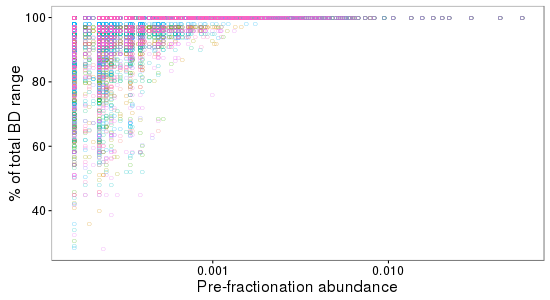

In [182]:
%%R -h 300 -w 550
## plotting
ggplot(df.SIM.j.f, aes(mean_bulk_abund, BD_range_perc, color=SIM_rep)) +
    geom_point(alpha=0.5, shape='O') +
    scale_x_log10() +
    scale_y_continuous() +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    #geom_vline(xintercept=0.001, linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank(),
        legend.position = 'none'
        )

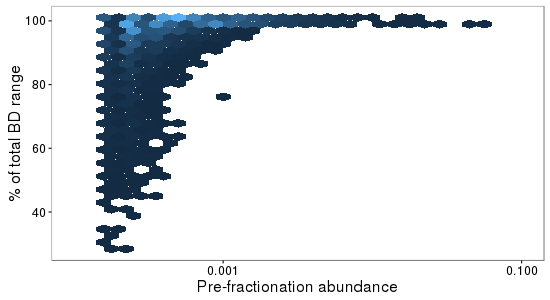

In [185]:
%%R -h 300 -w 550
## plotting
ggplot(df.SIM.j.f, aes(mean_bulk_abund, BD_range_perc)) +
    geom_hex() +
    scale_x_log10(limits=c(0.0001, 0.1)) +
    scale_y_continuous() +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    #geom_vline(xintercept=0.001, linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank(),
        legend.position = 'none'
        )

# Assessing diversity

### Asigning zeros

In [186]:
%%R
# giving value to missing abundances
min.pos.val = df.SIM.j %>%
    filter(rel_abund > 0) %>%
    group_by() %>%
    mutate(min_abund = min(rel_abund)) %>%
    ungroup() %>%
    filter(rel_abund == min_abund)

min.pos.val = min.pos.val[1,'rel_abund'] %>% as.numeric
imp.val = min.pos.val / 10


# convert numbers
df.SIM.j[df.SIM.j$rel_abund == 0, 'abundance'] = imp.val

# another closure operation
df.SIM.j = df.SIM.j %>%
    group_by(SIM_rep, fraction) %>%
    mutate(rel_abund = rel_abund / sum(rel_abund))


# status
cat('Below detection level abundances converted to: ', imp.val, '\n')

Below detection level abundances converted to:  3.408316e-06 


## Plotting Shannon diversity for each

In [187]:
%%R
shannon_index_long = function(df, abundance_col, ...){
    # calculating shannon diversity index from a 'long' formated table
    ## community_col = name of column defining communities
    ## abundance_col = name of column defining taxon abundances
    df = df %>% as.data.frame
    cmd = paste0(abundance_col, '/sum(', abundance_col, ')')
    df.s = df %>%
        group_by_(...) %>%
        mutate_(REL_abundance = cmd) %>%
        mutate(pi__ln_pi = REL_abundance * log(REL_abundance),
               shannon = -sum(pi__ln_pi, na.rm=TRUE)) %>%
        ungroup() %>% 
        dplyr::select(-REL_abundance, -pi__ln_pi) %>%
        distinct_(...) 
    return(df.s)
}

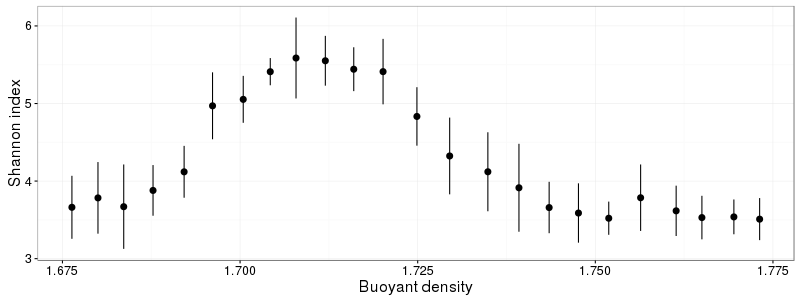

In [188]:
%%R -w 800 -h 300
# calculating shannon
df.SIM.shan = shannon_index_long(df.SIM.j, 'count', 'library', 'fraction') %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD) 

df.SIM.shan.s = df.SIM.shan %>%
    group_by(BD_bin = ntile(BD_mid, 24)) %>%
    summarize(mean_BD = mean(BD_mid),
              mean_shannon = mean(shannon),
              sd_shannon = sd(shannon))

# plotting
p = ggplot(df.SIM.shan.s, aes(mean_BD, mean_shannon, 
                             ymin=mean_shannon-sd_shannon,
                             ymax=mean_shannon+sd_shannon)) +
    geom_pointrange() +
    labs(x='Buoyant density', y='Shannon index') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

# Plotting variance

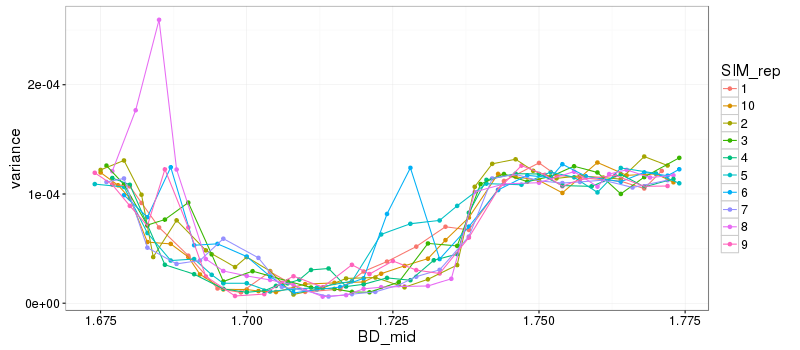

In [189]:
%%R -w 800 -h 350
df.SIM.j.var = df.SIM.j %>%
    group_by(SIM_rep, fraction) %>%
    mutate(variance = var(rel_abund)) %>%
    ungroup() %>%
    distinct(SIM_rep, fraction) %>%
    select(SIM_rep, fraction, variance, BD_mid)

ggplot(df.SIM.j.var, aes(BD_mid, variance, color=SIM_rep)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

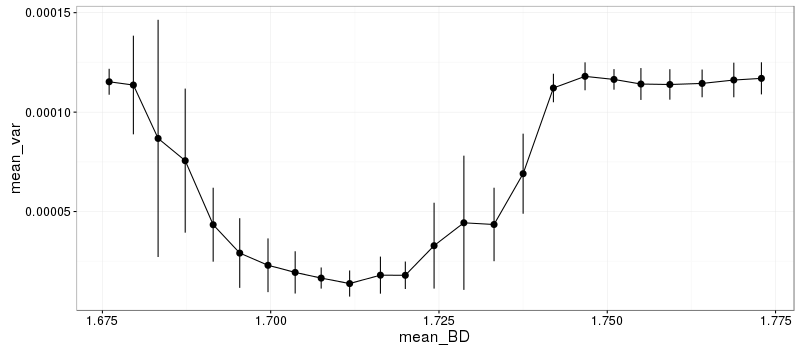

In [194]:
%%R -w 800 -h 350
df.SIM.j.var.s = df.SIM.j.var %>%
    group_by(BD_bin = ntile(BD_mid, 24)) %>%
    summarize(mean_BD = mean(BD_mid),
              mean_var = mean(variance),
              sd_var = sd(variance)) %>%
    ungroup()

ggplot(df.SIM.j.var.s, aes(mean_BD, mean_var, 
                         ymin=mean_var-sd_var,
                         ymax=mean_var+sd_var)) +
    geom_pointrange() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Notes

* spike at high G+C
  * absence of taxa or presence of taxa at those locations?

# Correlograms

In [202]:
%%R
BD.diffs = function(BDs){
    df.BD = expand.grid(BDs, BDs)
    df.BD$diff = df.BD %>% apply(1, diff) %>% abs %>% as.vector    
    df.BD = df.BD %>%
        spread(Var1, diff) 
    rownames(df.BD) = df.BD$Var2
    df.BD$Var2 = NULL
    dist.BD = df.BD %>% as.matrix
    dist.BD[upper.tri(dist.BD, diag=TRUE)] = 0
    dist.BD %>% as.dist
    }


SIM_reps = df.SIM.j$SIM_rep %>% unique
BDs.l = list()
for(sr in SIM_reps){
    tmp = df.SIM.j %>% filter(SIM_rep == sr) 
    BDs.l[[sr]] = tmp$BD_mid %>% unique
}

BD.dist.l = lapply(BDs.l, BD.diffs)
BD.dist.l %>% names

 [1] "7"  "9"  "8"  "3"  "10" "2"  "1"  "4"  "5"  "6" 


### Bray-curtis ~ BD_diff

In [251]:
%%R
# calculating fraction-fraction community dissimilarity
vegdist.by = function(sr, df, ...){
    df.w = df %>%
        filter(SIM_rep == sr) %>%
        select(taxon, fraction, abundance) %>%
        spread(taxon, abundance) %>%
        as.data.frame()
    
    rownames(df.w) = df.w$fraction
    df.w$fraction = NULL
    df.w$SIM_rep = NULL
    df.w[is.na(df.w)] = 0
    
    vegan::vegdist(df.w, ...)
}


SIM_reps = df.SIM.j$SIM_rep %>% unique
bray.l = list()
for (sr in SIM_reps){
    bray.l[[sr]] = vegdist.by(sr, df.SIM.j, method='bray')    
}
bray.l %>% names

 [1] "7"  "9"  "8"  "3"  "10" "2"  "1"  "4"  "5"  "6" 


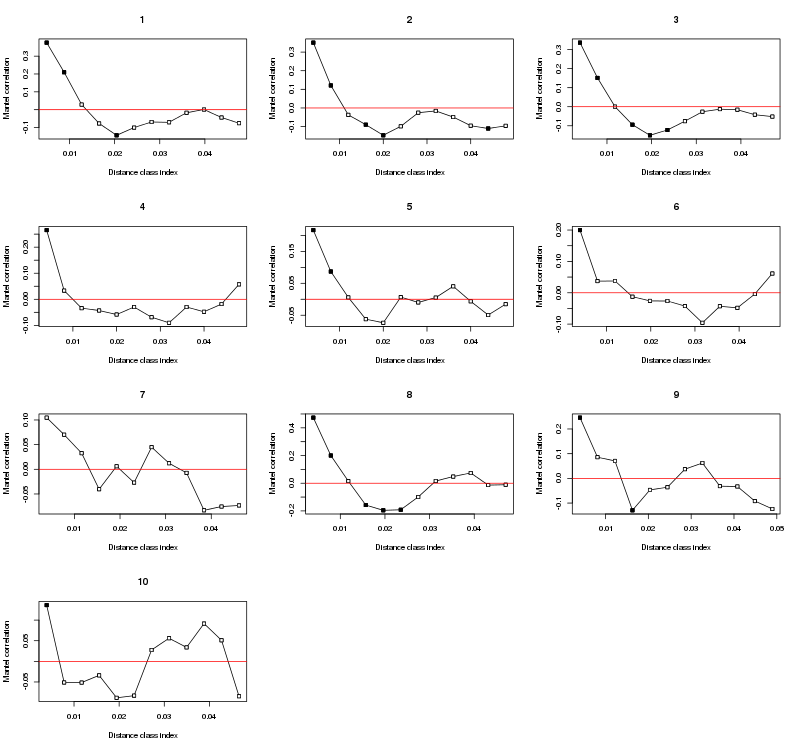

In [252]:
%%R -w 800 -h 750

cal.corr = function(d, BDs, nclass=24, ...){
    d[is.nan(d)] = 0
    stopifnot((d %>% length) == (BDs %>% length)) 
    vegan::mantel.correlog(d, BDs, n.class=nclass)
}

SIM_reps = df.SIM.j$SIM_rep %>% unique
corr.l = list()
for(sr in SIM_reps){
    corr.l[[sr]] = cal.corr(bray.l[[sr]], BD.dist.l[[sr]])
}

par(mfrow=c(4,3))
for (n in names(corr.l) %>% as.numeric %>% sort){
    plot(corr.l[[n]])
    title(n)
}

In [253]:
%%R
# making df of mantel values
corr.l.mantel = list()
for (n in corr.l %>% names){
    corr.l.mantel[[n]] = corr.l[[n]]['mantel.res'][[1]] %>% as.data.frame
    corr.l.mantel[[n]]$Day = n
    colnames(corr.l.mantel[[n]]) = c('class.index', 'n.dist', 'Mantel.corr', 'Pr', 'Pr.corr', 'Day')
}
df.corr = do.call(rbind, corr.l.mantel) %>% as.data.frame
df.corr %>% head

         class.index n.dist Mantel.corr    Pr Pr.corr Day
7.D.cl.1   0.0049375     46  0.37567861 0.001   0.001   7
7.D.cl.2   0.0088125     42  0.20974927 0.001   0.002   7
7.D.cl.3   0.0126875     42  0.02857775 0.295   0.295   7
7.D.cl.4   0.0165625     40 -0.07744649 0.090   0.180   7
7.D.cl.5   0.0204375     36 -0.14364415 0.002   0.006   7
7.D.cl.6   0.0243125     36 -0.10050422 0.025   0.075   7


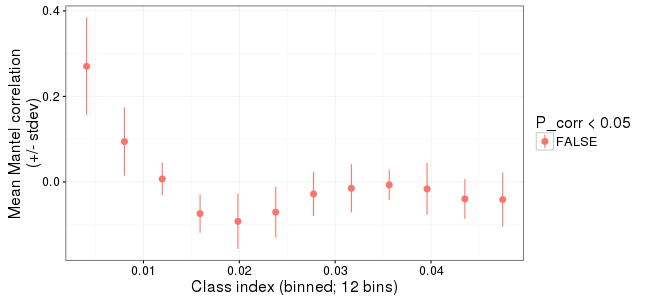

In [254]:
%%R -w 650 -h 300
# summarizing
df.corr.s = df.corr %>%
    filter(! is.na(Mantel.corr)) %>%
    group_by(bin = ntile(class.index, 12)) %>%
    summarize(n = n(),
              mean.class.index = mean(class.index),
              mean.Mantel.corr = mean(Mantel.corr, na.rm=TRUE),
              sd.Mantel.corr = sd(Mantel.corr, na.rm=TRUE),
              max.Pr.corr = max(Pr.corr, na.rm=TRUE)) %>%
    ungroup() %>%
    mutate(significant = ifelse(max.Pr.corr <= 0.05, TRUE, FALSE))


# plotting
ggplot(df.corr.s, aes(mean.class.index, mean.Mantel.corr, color=significant,
                      ymin=mean.Mantel.corr-sd.Mantel.corr,
                      ymax=mean.Mantel.corr+sd.Mantel.corr)) +
    geom_pointrange() +
    scale_color_discrete('P_corr < 0.05') +
    labs(x='Class index (binned; 12 bins)', y='Mean Mantel correlation\n(+/- stdev)') +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    ) 

### Binary ~ BD_diff

In [255]:
%%R
SIM_reps = df.SIM.j$SIM_rep %>% unique
binary.l = list()
for (sr in SIM_reps){
    binary.l[[sr]] = vegdist.by(sr, df.SIM.j, binary=TRUE)    
}
binary.l %>% names

 [1] "7"  "9"  "8"  "3"  "10" "2"  "1"  "4"  "5"  "6" 


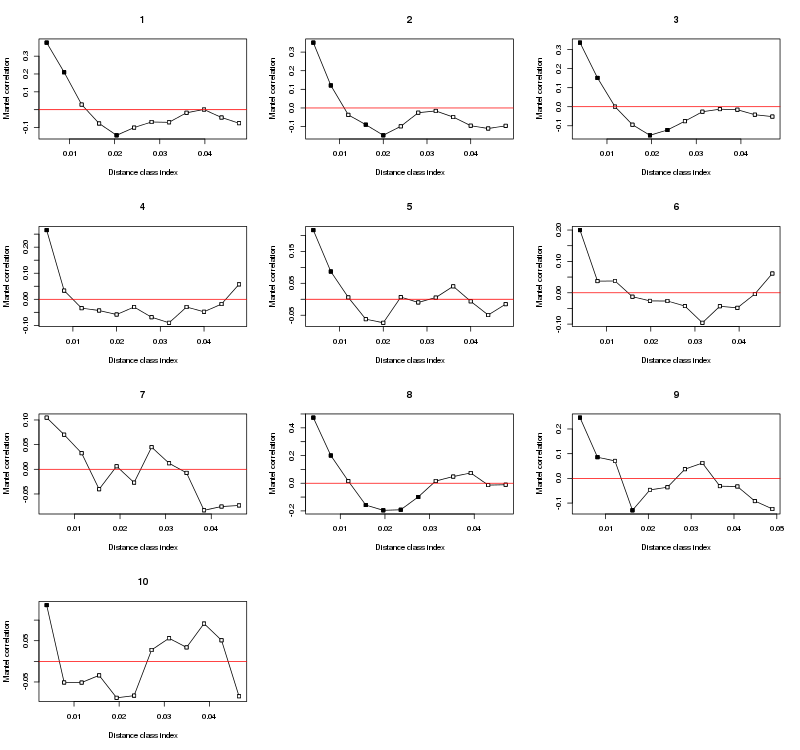

In [256]:
%%R -w 800 -h 750

SIM_reps = df.SIM.j$SIM_rep %>% unique
corr.l = list()
for(sr in SIM_reps){
    corr.l[[sr]] = cal.corr(binary.l[[sr]], BD.dist.l[[sr]])
}

par(mfrow=c(4,3))
for (n in names(corr.l) %>% as.numeric %>% sort){
    plot(corr.l[[n]])
    title(n)
}

In [257]:
%%R
# making df of mantel values
corr.l.mantel = list()
for (n in corr.l %>% names){
    corr.l.mantel[[n]] = corr.l[[n]]['mantel.res'][[1]] %>% as.data.frame
    corr.l.mantel[[n]]$Day = n
    colnames(corr.l.mantel[[n]]) = c('class.index', 'n.dist', 'Mantel.corr', 'Pr', 'Pr.corr', 'Day')
}
df.corr = do.call(rbind, corr.l.mantel) %>% as.data.frame
df.corr %>% head

         class.index n.dist Mantel.corr    Pr Pr.corr Day
7.D.cl.1   0.0049375     46  0.37567861 0.001   0.001   7
7.D.cl.2   0.0088125     42  0.20974927 0.001   0.002   7
7.D.cl.3   0.0126875     42  0.02857775 0.281   0.281   7
7.D.cl.4   0.0165625     40 -0.07744649 0.072   0.144   7
7.D.cl.5   0.0204375     36 -0.14364415 0.003   0.009   7
7.D.cl.6   0.0243125     36 -0.10050422 0.029   0.087   7


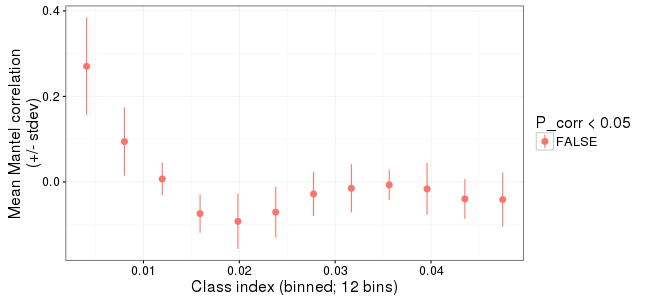

In [258]:
%%R -w 650 -h 300
# summarizing
df.corr.s = df.corr %>%
    filter(! is.na(Mantel.corr)) %>%
    group_by(bin = ntile(class.index, 12)) %>%
    summarize(n = n(),
              mean.class.index = mean(class.index),
              mean.Mantel.corr = mean(Mantel.corr, na.rm=TRUE),
              sd.Mantel.corr = sd(Mantel.corr, na.rm=TRUE),
              max.Pr.corr = max(Pr.corr, na.rm=TRUE)) %>%
    ungroup() %>%
    mutate(significant = ifelse(max.Pr.corr <= 0.05, TRUE, FALSE))


# plotting
ggplot(df.corr.s, aes(mean.class.index, mean.Mantel.corr, color=significant,
                      ymin=mean.Mantel.corr-sd.Mantel.corr,
                      ymax=mean.Mantel.corr+sd.Mantel.corr)) +
    geom_pointrange() +
    scale_color_discrete('P_corr < 0.05') +
    labs(x='Class index (binned; 12 bins)', y='Mean Mantel correlation\n(+/- stdev)') +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    ) 

# Plotting absolute abundance distributions 

In [195]:
OTU_files = !find $buildDir -name "OTU_abs1e9.txt"
OTU_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/7/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/9/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/8/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/3/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/10/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/2/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/1/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/4/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/5/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/6/OTU_abs1e9.txt']

In [196]:
%%R -i OTU_files
# loading files

df.abs = list()
for (x in OTU_files){
    SIM_rep = gsub('/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/', '', x)
    SIM_rep = gsub('/OTU_abs1e9.txt', '', SIM_rep)
    df.abs[[SIM_rep]] = read.delim(x, sep='\t') 
    }
df.abs = do.call('rbind', df.abs)
df.abs$SIM_rep = gsub('\\.[0-9]+$', '', rownames(df.abs))
rownames(df.abs) = 1:nrow(df.abs)
df.abs %>% head(n=3)

  library                          taxon    fraction BD_min BD_mid BD_max count
1       1 Acaryochloris_marina_MBIC11017  -inf-1.660   -Inf  1.659  1.659    10
2       1 Acaryochloris_marina_MBIC11017 1.660-1.664  1.660  1.662  1.664     4
3       1 Acaryochloris_marina_MBIC11017 1.664-1.667  1.664  1.665  1.667     4
     rel_abund SIM_rep
1 2.191036e-05       7
2 3.083517e-05       7
3 4.024712e-05       7


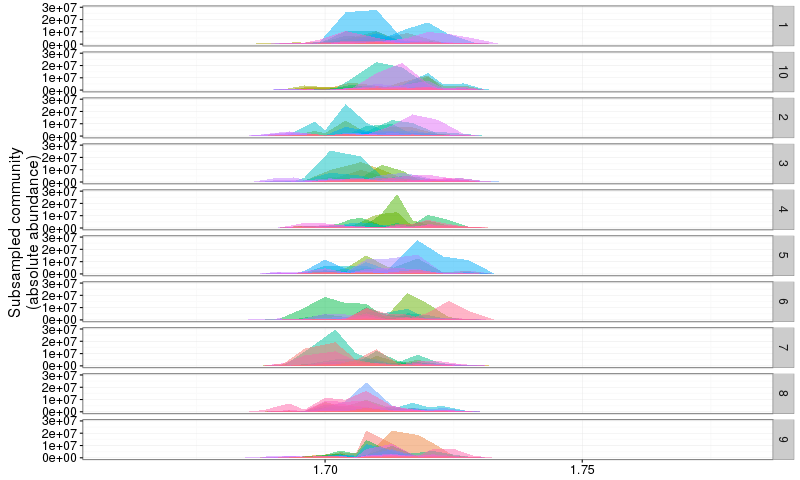

In [197]:
%%R -w 800 

ggplot(df.abs, aes(BD_mid, count, fill=taxon)) +
    geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)') +
    facet_grid(SIM_rep ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )

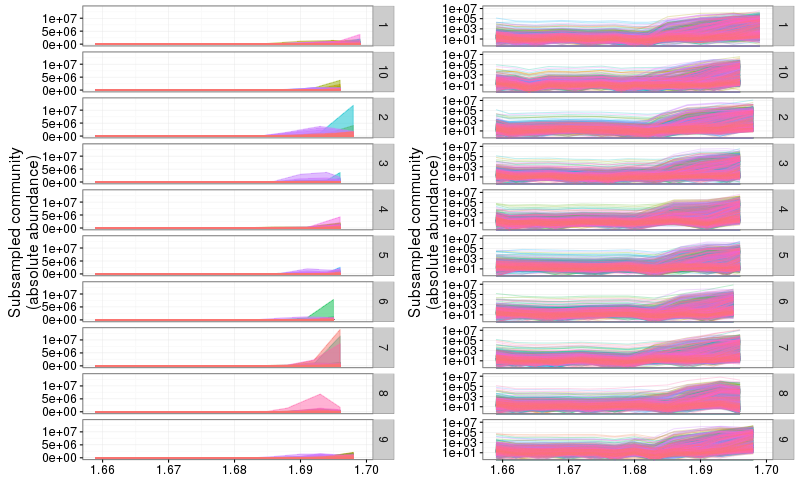

In [198]:
%%R -w 800 

p1 = ggplot(df.abs %>% filter(BD_mid < 1.7), aes(BD_mid, count, fill=taxon, color=taxon)) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)') +
    facet_grid(SIM_rep ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )

p2 = p1 + geom_line(alpha=0.25) + scale_y_log10()
p1 = p1 + geom_area(stat='identity', position='dodge', alpha=0.5) 

grid.arrange(p1, p2, ncol=2)

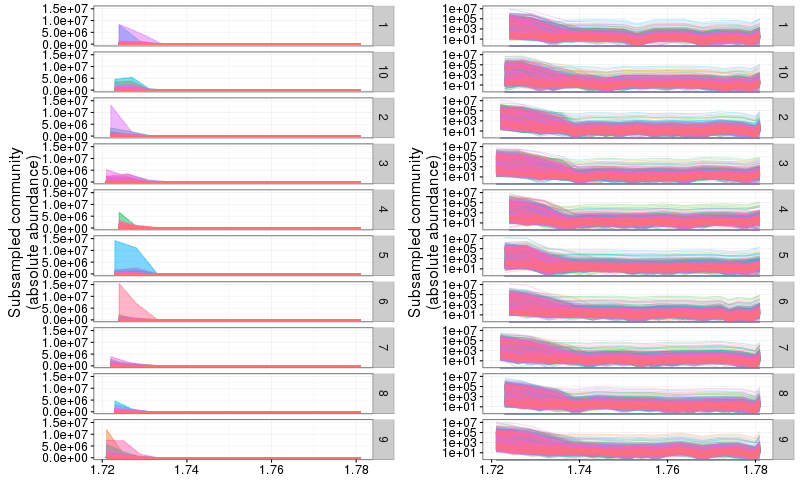

In [199]:
%%R -w 800 

p1 = ggplot(df.abs %>% filter(BD_mid > 1.72), aes(BD_mid, count, fill=taxon, color=taxon)) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)') +
    facet_grid(SIM_rep ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )


p2 = p1 + geom_line(alpha=0.25) + scale_y_log10()
p1 = p1 + geom_area(stat='identity', position='dodge', alpha=0.5) 

grid.arrange(p1, p2, ncol=2)